In [3]:
!pip install gym

     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     -------------- ------------------------- 262.1/721.7 kB ? eta -:--:--
     -------------------------------------- 721.7/721.7 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827705 sha256=39991533afd7ccf19475859abc585b287fc8512768d7663d20cb1005578d6f26
  Stored in directory: c:\users\adisu\appdata\local\pip\cache\wheels\95\51\6c\9bb05ebbe7c5cb8171dfaa3611f32622ca4658d53f31c79077
Successfully built gym


## Exercise 1: Monte Carlo - Blackjack Policy Evaluation

C:\Users\Adisu\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


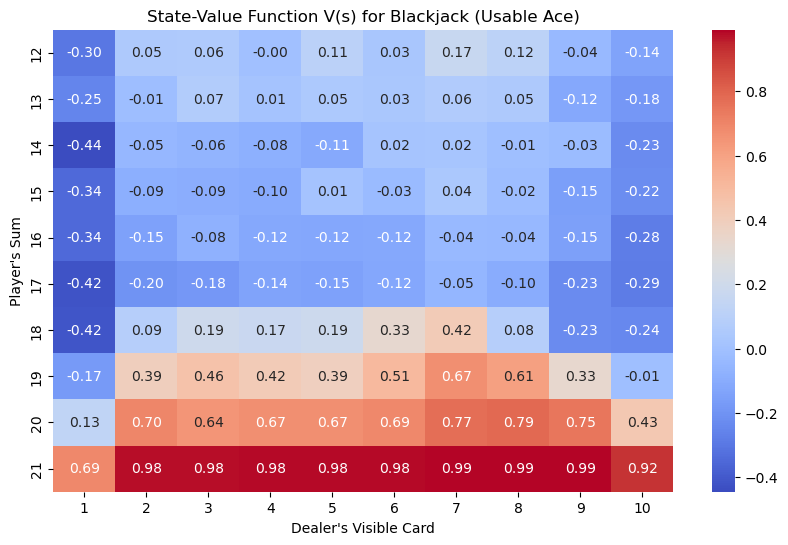

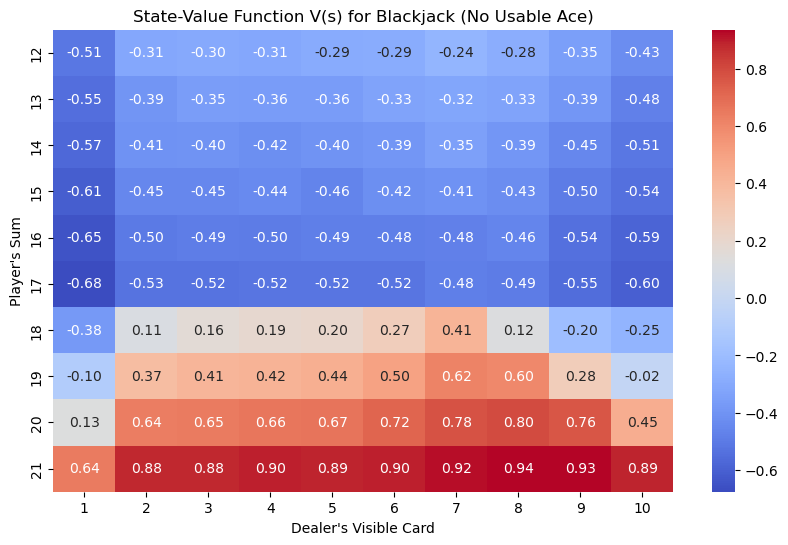

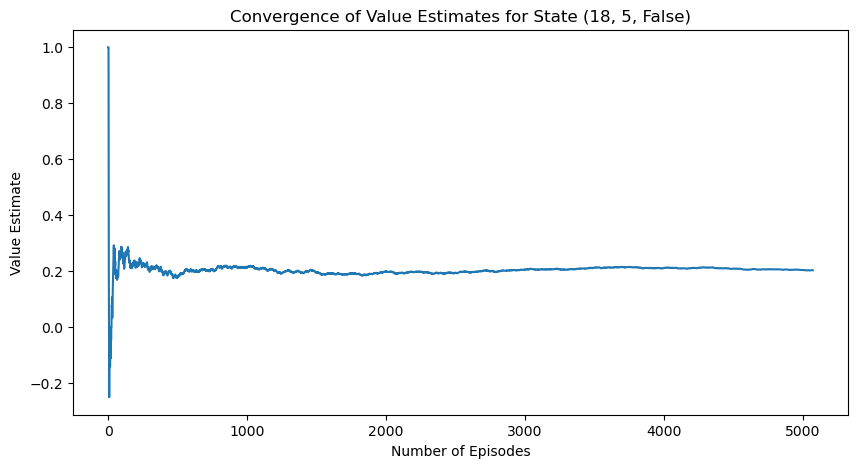

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Blackjack environment
env = gym.make('Blackjack-v1', sab=True)  # `sab=True` for better strategy handling

# Define the policy
def policy(player_sum):
    return 0 if player_sum >= 18 else 1  # 0 = stick, 1 = hit

# Initialize the value function and returns dictionary
V = np.zeros((10, 11, 2))  # Player sum (12-21), dealer's visible card (1-10), usable_ace (0/1)
returns = { (player_sum, dealer_card, usable_ace): [] 
            for player_sum in range(12, 22)  # Player sum ranges from 12 to 21
            for dealer_card in range(1, 11)  # Dealer's card ranges from 1 to 10
            for usable_ace in [True, False] }  # Usable ace is a boolean

# Monte Carlo parameters
num_episodes = 500000
gamma = 1.0  # Discount factor

# Monte Carlo simulation
for episode in range(num_episodes):
    state, _ = env.reset()
    episode_history = []  # List to store (state, action, reward) tuples
    done = False

    while not done:
        player_sum, dealer_card, usable_ace = state  # Unpack the state
        action = policy(player_sum)  # Pass player_sum to the policy function
        next_state, reward, done, _, _ = env.step(action)

        # Only store states where player_sum is >= 12
        if player_sum >= 12:
            episode_history.append((state, action, reward))

        state = next_state  # Move to next state

    # Calculate returns and update value function
    G = 0
    for t in range(len(episode_history) - 1, -1, -1):
        state, action, reward = episode_history[t]
        G = gamma * G + reward
        if state not in [x[0] for x in episode_history[:t]]:  # First-visit MC
            returns[state].append(G)
            player_sum, dealer_card, usable_ace = state
            V[player_sum - 12, dealer_card, int(usable_ace)] = np.mean(returns[state])

# Plot the value function
def plot_value_function(V, usable_ace):
    player_sum_range = range(12, 22)
    dealer_card_range = range(1, 11)

    values = np.zeros((len(player_sum_range), len(dealer_card_range)))
    for i, player_sum in enumerate(player_sum_range):
        for j, dealer_card in enumerate(dealer_card_range):
            values[i, j] = V[player_sum - 12, dealer_card, int(usable_ace)]

    plt.figure(figsize=(10, 6))
    sns.heatmap(values, xticklabels=dealer_card_range, yticklabels=player_sum_range, annot=True, fmt=".2f", cmap="coolwarm")
    title = "Usable Ace" if usable_ace else "No Usable Ace"
    plt.title(f"State-Value Function V(s) for Blackjack ({title})")
    plt.xlabel("Dealer's Visible Card")
    plt.ylabel("Player's Sum")
    plt.show()

plot_value_function(V, usable_ace=True)
plot_value_function(V, usable_ace=False)

# Plot convergence of value estimates
def plot_convergence(returns, state):
    if state in returns and len(returns[state]) > 0:
        plt.figure(figsize=(10, 5))
        plt.plot(np.cumsum(returns[state]) / (np.arange(len(returns[state])) + 1))
        plt.title(f"Convergence of Value Estimates for State {state}")
        plt.xlabel("Number of Episodes")
        plt.ylabel("Value Estimate")
        plt.show()
    else:\                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
        print(f"No data available for state {state}")

# Example: Plot convergence for a specific state
example_state = (18, 5, False)  # Player sum = 18, dealer's card = 5, no usable ace
plot_convergence(returns, example_state)

## Exercise 2: Temporal Difference - Cliff Walking with SARSA

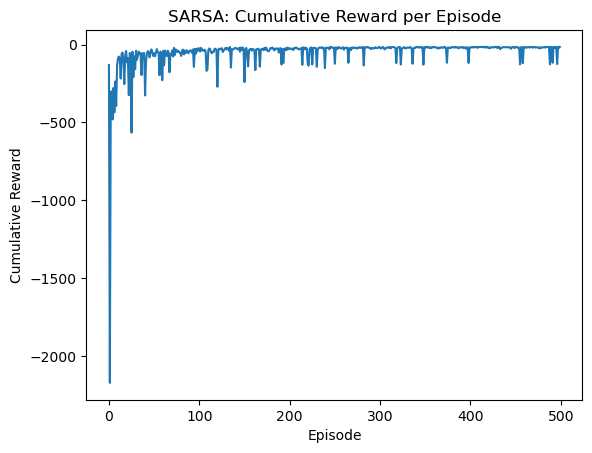

Learned Policy:
[['↓' '↓' '→' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '→']
 ['↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '→']
 ['←' '←' '↓' '↑' '←' '←' '↑' '←' '←' '↑' '↓' '→']
 ['←' '←' '←' '←' '←' '←' '←' '←' '←' '←' '←' '←']]


In [27]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 1.0  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 500

# Initialize environment
env = gym.make('CliffWalking-v0')
n_states = env.observation_space.n
n_actions = env.action_space.n

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

# Track cumulative rewards per episode
cumulative_rewards = []

# SARSA algorithm
for episode in range(num_episodes):
    state = env.reset()[0]  # Extract the state from the tuple
    action = np.argmax(Q[state, :]) if np.random.rand() > epsilon else env.action_space.sample()
    total_reward = 0

    while True:
        # Take action and observe next state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated  # Combine terminated and truncated into a single flag
        
        # Choose next action using ε-greedy policy
        next_action = np.argmax(Q[next_state, :]) if np.random.rand() > epsilon else env.action_space.sample()
        
        # Update Q-value using SARSA
        Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
        
        # Update state and action
        state, action = next_state, next_action
        total_reward += reward

        if done:
            break

    cumulative_rewards.append(total_reward)

# Plot cumulative rewards
plt.plot(cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('SARSA: Cumulative Reward per Episode')
plt.show()

# Visualize the learned policy
policy = np.argmax(Q, axis=1).reshape(4, 12)
arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
policy_arrows = np.vectorize(arrows.get)(policy)

print("Learned Policy:")
print(policy_arrows)